https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/victormp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#basics 
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [8]:
#gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModelimport #throws error. 


ImportError: cannot import name 'CoherenceModelimport' from 'gensim.models' (/home/victormp/anaconda3/envs/nlp/lib/python3.8/site-packages/gensim/models/__init__.py)

In [9]:
# spacy for lemmatization
import spacy

In [10]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/victormp/anaconda3/envs/nlp/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5. Prepare stopwords: 

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

6. Import newsgroup data-set:


In [15]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


7. Remove emal and newline characters. 

In [17]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


8. Tokenize and clean up

In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


9. Bi-gram and tri-gram based on frequent occurence.
(takes some time to run). 

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


10. Remove stopwords, make bigrams and lemmatize. 

In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Using the functions.
(takes some time to run). 

In [21]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


11. Create dictionary and corpus for topic modelling.

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [24]:
### frequency plot of words? ### 
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

12. Building the topic model (takes a long time to run).  

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, #20 topics
                                           random_state=100, #seed
                                           update_every=1, #
                                           chunksize=100, #
                                           passes=10, #
                                           alpha='auto', #hyper-parameter. 
                                           per_word_topics=True)

In [26]:
?gensim.models.ldamodel.LdaModel

13. view topics in LDA model. 

In [32]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.175*"file" + 0.073*"entry" + 0.057*"error" + 0.053*"display" + '
  '0.040*"program" + 0.030*"sun" + 0.025*"version" + 0.024*"cool" + '
  '0.020*"output" + 0.020*"crash"'),
 (1,
  '0.032*"would" + 0.026*"say" + 0.022*"think" + 0.022*"people" + 0.020*"go" + '
  '0.018*"know" + 0.016*"make" + 0.016*"see" + 0.014*"come" + 0.013*"thing"'),
 (2,
  '0.091*"evidence" + 0.048*"book" + 0.041*"faith" + 0.037*"reason" + '
  '0.033*"exist" + 0.032*"claim" + 0.031*"religion" + 0.029*"believe" + '
  '0.027*"christian" + 0.023*"church"'),
 (3,
  '0.541*"ax" + 0.054*"car" + 0.028*"player" + 0.014*"engine" + 0.009*"dealer" '
  '+ 0.009*"mile" + 0.009*"expensive" + 0.009*"here" + 0.008*"extra" + '
  '0.008*"specify"'),
 (4,
  '0.087*"belief" + 0.084*"internet" + 0.079*"atheist" + 0.061*"distribution" '
  '+ 0.053*"wing" + 0.041*"atheism" + 0.038*"printer" + 0.034*"interface" + '
  '0.026*"multiple" + 0.020*"thinking"'),
 (5,
  '0.088*"normal" + 0.072*"port" + 0.071*"mouse" + 0.053*"hole" + 0.03

This is what StatQuest refers to as the "recipe" for each of the Principal Components. They are linear combinations of different dimensions/topics. Leading to new dimensions (sort of transformation). 

14. Computer model perplexity and coherence score

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_lemmatized, 
                                     dictionary=id2word, 
                                     coherence='c_v') # 'u_mass' is faster computationally.
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.486503413641383

Coherence Score:  0.49288861569721343


15. Visualize the topics-keywords: 

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.335627 -0.217745       1        1  28.085217
18    -0.302093 -0.145063       2        1  18.153990
9     -0.271870 -0.004537       3        1  15.586853
19    -0.213916  0.101545       4        1   8.162782
3      0.014729  0.121688       5        1   5.748532
10    -0.144864  0.268438       6        1   5.679879
6     -0.129660  0.185644       7        1   5.134195
2     -0.061842 -0.076502       8        1   2.129767
14    -0.018008 -0.093220       9        1   1.930819
16     0.000212  0.059319      10        1   1.922101
11     0.069658  0.074444      11        1   1.423860
0      0.119144  0.020978      12        1   1.152387
12     0.109095 -0.008046      13        1   1.039408
8      0.085481 -0.055229      14        1   0.971931
7      0.131145 -0.010047      15        1   0.884551
4      0.160738 -0.037304      16        1   0.697291
13     0.172285 -0.042792      17        1   0.449756
15     0.198402 -0.044230      18        1   0.375347
5      0.200337 -0.048561      19        1   0.334445
17     0.216654 -0.048779      20        1   0.136887, topic_info=              Term          Freq         Total Category  logprob  loglift
3718            ax  36366.000000  36366.000000  Default  30.0000  30.0000
18            line  15682.000000  15682.000000  Default  29.0000  29.0000
197          write  13139.000000  13139.000000  Default  28.0000  28.0000
39            year   4567.000000   4567.000000  Default  27.0000  27.0000
140         people   7716.000000   7716.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
6226  redistribute      0.026008      1.250146  Topic20 -11.0266   2.7211
6951     judgement      0.026008      1.250164  Topic20 -11.0266   2.7211
9115      tomorrow      0.026008      1.250169  Topic20 -11.0266   2.7211
5664  announcement      0.026008      1.250197  Topic20 -11.0266   2.7211
4072          baby      0.026008      1.250174  Topic20 -11.0266   2.7211

[866 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1227      1  0.999082        accept
345      15  0.914017    acceptance
326      17  0.943324  accidentally
0         7  0.998126      addition
175       2  0.399800       address
...     ...       ...           ...
39        1  0.028244          year
39        3  0.824319          year
39       14  0.147348          year
722      13  0.992126     yesterday
570       1  0.998438         young

[1113 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 19, 10, 20, 4, 11, 7, 3, 15, 17, 12, 1, 13, 9, 8, 5, 14, 16, 6, 18])

16. LDA mallet (improvement) (below takes time to run)

In [36]:
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)



In [37]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(11,
  [('space', 0.023034339406537003),
   ('system', 0.01177169279063355),
   ('design', 0.008568943941290008),
   ('launch', 0.007975056737438225),
   ('project', 0.007720533650073176),
   ('year', 0.007105436188940972),
   ('technology', 0.006850913101575922),
   ('earth', 0.006638810528771714),
   ('time', 0.006214605383163298),
   ('high', 0.006044923324919931)]),
 (12,
  [('people', 0.017638816913303008),
   ('book', 0.01128577186618299),
   ('man', 0.010997869522657914),
   ('church', 0.00923206848237078),
   ('turkish', 0.008425941920500566),
   ('history', 0.00836836145179555),
   ('world', 0.008272394003953859),
   ('armenian', 0.008234007024817183),
   ('today', 0.00777336327517706),
   ('find', 0.0071399781194218925)]),
 (4,
  [('gun', 0.023727382831137372),
   ('law', 0.0175065144786582),
   ('state', 0.0159283590854039),
   ('kill', 0.015653099423789774),
   ('crime', 0.009615737512386684),
   ('people', 0.009579036224171469),
   ('attack', 0.009505633647741036),
   ('i

In [38]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, #actually works somehow?
                                           texts=data_lemmatized, 
                                           dictionary=id2word, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet) ## .49 --> .57 (pretty good improvement). 


Coherence Score:  0.5721462097501041


17. Find optimal number of topics for LDA :

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [41]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2,  ## starts with 2 topics. 
                                                        limit=40,  ## maximum of 40 topics. 
                                                        step=6) ## 2 --> 8 --> 14 --> etc. 

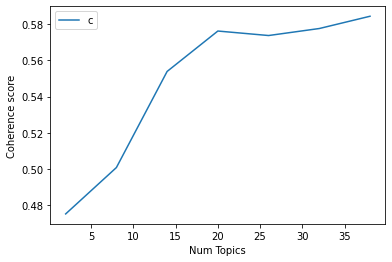

In [42]:
# Show graph --> looks like 20 topics is pretty good. 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show() 

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4752
Num Topics = 8  has Coherence Value of 0.5008
Num Topics = 14  has Coherence Value of 0.5539
Num Topics = 20  has Coherence Value of 0.5762
Num Topics = 26  has Coherence Value of 0.5737
Num Topics = 32  has Coherence Value of 0.5776
Num Topics = 38  has Coherence Value of 0.5844


In [46]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"people" + 0.017*"happen" + 0.016*"day" + 0.014*"start" + '
  '0.013*"time" + 0.012*"leave" + 0.012*"hear" + 0.010*"fire" + 0.010*"child" '
  '+ 0.009*"back"'),
 (1,
  '0.022*"include" + 0.018*"list" + 0.015*"send" + 0.015*"software" + '
  '0.013*"mail" + 0.012*"information" + 0.012*"version" + 0.012*"system" + '
  '0.011*"base" + 0.011*"support"'),
 (2,
  '0.035*"drive" + 0.029*"problem" + 0.027*"card" + 0.022*"system" + '
  '0.018*"work" + 0.017*"driver" + 0.015*"run" + 0.014*"disk" + 0.014*"bit" + '
  '0.014*"memory"'),
 (3,
  '0.972*"ax" + 0.001*"tq" + 0.001*"tg" + 0.000*"wwiz" + 0.000*"ei_ei" + '
  '0.000*"mb" + 0.000*"eqtm" + 0.000*"tm" + 0.000*"end" + 0.000*"part"'),
 (4,
  '0.020*"power" + 0.015*"line" + 0.012*"current" + 0.012*"work" + '
  '0.011*"ground" + 0.009*"high" + 0.009*"wire" + 0.008*"water" + 0.007*"low" '
  '+ 0.007*"hot"'),
 (5,
  '0.017*"system" + 0.016*"information" + 0.016*"encryption" + '
  '0.015*"government" + 0.014*"technology" + 0.010*"securit

18. Finding dominant topic in each sentence (takes time). 

In [47]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1673,"car, bike, ride, drive, engine, back, turn, go...",From: (wheres my thing) Subject: WHAT car is t...
1,1,2.0,0.1747,"drive, problem, card, system, work, driver, ru...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,12.0,0.1349,"good, make, thing, people, post, read, bad, wr...",From: (Thomas E Willis) Subject: PB questions....
3,3,15.0,0.1146,"write, article, line, nntp_poste, organization...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,11.0,0.1186,"file, window, program, line, set, display, col...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,8.0,0.3416,"gun, law, state, people, case, crime, person, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,12.0,0.1009,"good, make, thing, people, post, read, bad, wr...",From: (brian manning delaney) Subject: Brain T...
7,7,2.0,0.4644,"drive, problem, card, system, work, driver, ru...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,11.0,0.1380,"file, window, program, line, set, display, col...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,2.0,0.2330,"drive, problem, card, system, work, driver, ru...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


19. Most representative document for each topic (reverse idea).

In [48]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8367,"people, happen, day, start, time, leave, hear,...",From: (David Davidian) Subject: Accounts of An...
1,1.0,0.7222,"include, list, send, software, mail, informati...",From: (Marc Conrad) Subject: Re: List of large...
2,2.0,0.7719,"drive, problem, card, system, work, driver, ru...",From: (D. Keith Rice) Subject: Re: Drive/Contr...
3,3.0,0.9949,"ax, tq, tg, wwiz, ei_ei, mb, eqtm, tm, end, part",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
4,4.0,0.7297,"power, line, current, work, ground, high, wire...","From: Subject: Grounding power wiring, was Re:..."


20. Topic distribution across documents: 

In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,9.0,"car, bike, ride, drive, engine, back, turn, go...",341.0,0.0301
1.0,2.0,"drive, problem, card, system, work, driver, ru...",564.0,0.0498
2.0,12.0,"good, make, thing, people, post, read, bad, wr...",1218.0,0.1077
3.0,15.0,"write, article, line, nntp_poste, organization...",10.0,0.0009
4.0,11.0,"file, window, program, line, set, display, col...",502.0,0.0444
...,...,...,...,...
11309.0,18.0,"study, drug, problem, food, doctor, effect, fi...",NaN,NaN
11310.0,2.0,"drive, problem, card, system, work, driver, ru...",NaN,NaN
11311.0,2.0,"drive, problem, card, system, work, driver, ru...",NaN,NaN
11312.0,10.0,"key, line, bit, number, call, time, message, p...",NaN,NaN
